In [2]:
import pandas as pd
from dotmap import DotMap
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys

from pluma.stream.harp import HarpStream

plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
data_path = 'D:/Collection2023_08_16_15_00_04/'

# Load relevant streams
pellet_monitor = pd.read_csv(data_path + 'PelletMonitor.csv')
pellet_monitor.columns = ['Seconds', 'Value']
pellet_monitor.set_index('Seconds', inplace=True)

pellets_detected = pd.read_csv(data_path + 'PelletsDetected.csv')
pellets_detected.columns = ['Seconds', 'Value']
pellets_detected.set_index('Seconds', inplace=True)

pixel_sum = pd.read_csv(data_path + 'PixelSum.csv')
pixel_sum.columns = ['Seconds', 'Value']
pixel_sum.set_index('Seconds', inplace=True)

cam_frames = pd.read_csv(data_path + 'CameraFrameIndex.csv')
cam_frames.columns = ['Seconds', 'Value']
cam_frames.set_index('Seconds', inplace=True)

In [5]:
# Setup functions defs
def get_frame_at_index(idx, vid):
    capture = cv2.VideoCapture(vid)
    capture.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = capture.read()

    return frame

FMP4


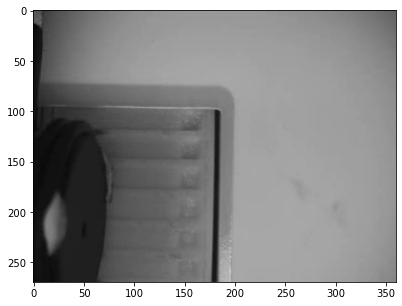

394827.0 394827


In [7]:
# Video check
cap = cv2.VideoCapture(data_path + 'PatchVideo.avi')
print(int(cap.get(cv2.CAP_PROP_FOURCC)).to_bytes(4, byteorder=sys.byteorder).decode())
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

cap.set(cv2.CAP_PROP_POS_FRAMES, 87197)
ret, frame = cap.read()

plt.imshow(frame)
plt.show()

# Frame n check
print(total_frames, len(cam_frames))

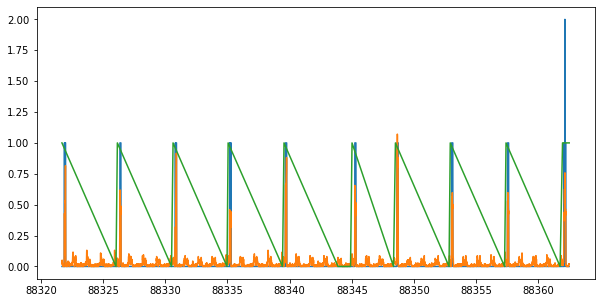

In [8]:
# Summary plot
plot_range_start = pellet_monitor.index[100]
plot_range_end = pellet_monitor.index[120]

plt.figure()
plt.plot(pellets_detected["Value"][plot_range_start:plot_range_end])
plt.plot(pixel_sum["Value"][plot_range_start:plot_range_end] / 35000)
plt.plot(pellet_monitor["Value"][plot_range_start:plot_range_end])

In [9]:
# Add some extra flags to the pellet monitor for non-standard delivery patterns
# find delivery retry times
pellet_monitor['delivery_retry'] = pellet_monitor.Value.diff().eq(0) & pellet_monitor.Value.eq(0)
pellet_monitor['retry_count'] = pellet_monitor.groupby((pellet_monitor['delivery_retry'] == 0).cumsum())['delivery_retry'].cumsum()

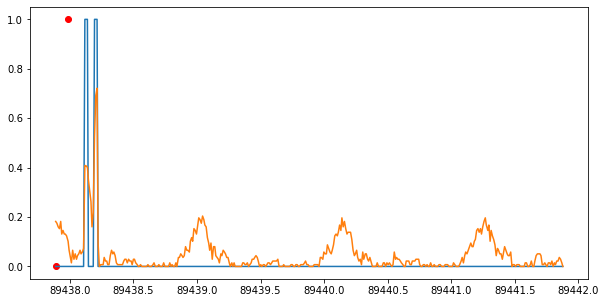

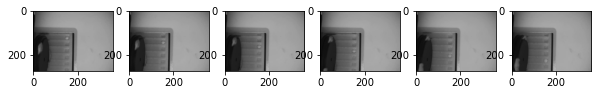

In [14]:
# Camera frames around pellet delivery times
time_win_s = 4
delivery_dt = pellet_monitor[pellet_monitor['Value'] == 0]
dt = delivery_dt.index[300]

# window for delivery
monitor_in_win = pellet_monitor['Value'][(pellet_monitor.index >= dt) & (pellet_monitor.index <= dt+time_win_s)]
pellets_in_win = pellets_detected['Value'][(pellets_detected.index >= dt) & (pellets_detected.index <= dt+time_win_s)]
pix_in_win = pixel_sum['Value'][(pixel_sum.index >= dt) & (pixel_sum.index <= dt+time_win_s)]

# plot time course
plt.figure()
plt.plot(pellets_in_win)
plt.plot(pix_in_win / 35000)
plt.scatter(monitor_in_win.index, monitor_in_win.values, c='r')

# Time when camera detected pellet
pellet_dt = pellets_in_win[pellets_in_win.values > 0].index[0]
# Frame index for that time
frame_idx = cam_frames[cam_frames.index >= pellet_dt].values[0][0]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
ax1.imshow(get_frame_at_index(frame_idx - 2, data_path + 'PatchVideo.avi'))
ax2.imshow(get_frame_at_index(frame_idx, data_path + 'PatchVideo.avi'))
ax3.imshow(get_frame_at_index(frame_idx + 2, data_path + 'PatchVideo.avi'))
ax4.imshow(get_frame_at_index(frame_idx + 4, data_path + 'PatchVideo.avi'))
ax5.imshow(get_frame_at_index(frame_idx + 6, data_path + 'PatchVideo.avi'))
ax6.imshow(get_frame_at_index(frame_idx + 8, data_path + 'PatchVideo.avi'))
plt.show()

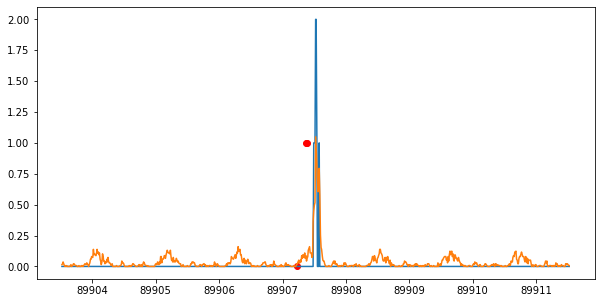

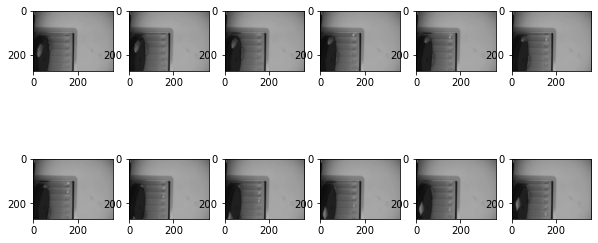

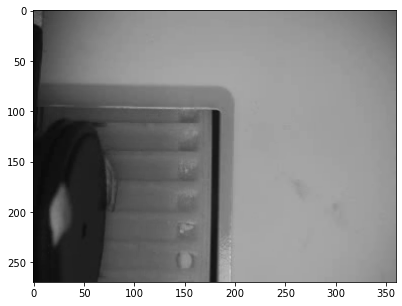

In [19]:
# Are there any multi deliveries present?
multi_pellet_dt = pellets_detected[pellets_detected['Value'].ge(2)]
dt = multi_pellet_dt.index[15] # choose which of the multi pellet timestamps to center around

# data window
monitor_in_win = pellet_monitor['Value'][(pellet_monitor.index >= dt-time_win_s) & (pellet_monitor.index <= dt+time_win_s)]
pellets_in_win = pellets_detected['Value'][(pellets_detected.index >= dt-time_win_s) & (pellets_detected.index <= dt+time_win_s)]
pix_in_win = pixel_sum['Value'][(pixel_sum.index >= dt-time_win_s) & (pixel_sum.index <= dt+time_win_s)]

# plot time course
plt.figure()
plt.plot(pellets_in_win)
plt.plot(pix_in_win / 35000)
plt.scatter(monitor_in_win.index, monitor_in_win.values, c='r')

# Time when camera first detected pellet
pellet_dt = pellets_in_win[pellets_in_win.values > 0].index[0]
# Frame index for that time
frame_idx = cam_frames[cam_frames.index >= pellet_dt].values[0][0]

# DEBUG group by time


fig, axs = plt.subplots(2, 6)
axs[0,0].imshow(get_frame_at_index(frame_idx - 10, data_path + 'PatchVideo.avi'))
axs[0,1].imshow(get_frame_at_index(frame_idx - 8, data_path + 'PatchVideo.avi'))
axs[0,2].imshow(get_frame_at_index(frame_idx - 6, data_path + 'PatchVideo.avi'))
axs[0,3].imshow(get_frame_at_index(frame_idx - 4, data_path + 'PatchVideo.avi'))
axs[0,4].imshow(get_frame_at_index(frame_idx - 3, data_path + 'PatchVideo.avi'))
axs[0,5].imshow(get_frame_at_index(frame_idx - 2, data_path + 'PatchVideo.avi'))
axs[1,0].imshow(get_frame_at_index(frame_idx + 0, data_path + 'PatchVideo.avi'))
axs[1,1].imshow(get_frame_at_index(frame_idx + 2, data_path + 'PatchVideo.avi'))
axs[1,2].imshow(get_frame_at_index(frame_idx + 4, data_path + 'PatchVideo.avi'))
axs[1,3].imshow(get_frame_at_index(frame_idx + 6, data_path + 'PatchVideo.avi'))
axs[1,4].imshow(get_frame_at_index(frame_idx + 8, data_path + 'PatchVideo.avi'))
axs[1,5].imshow(get_frame_at_index(frame_idx + 10, data_path + 'PatchVideo.avi'))
plt.show()

plt.figure()
plt.imshow(get_frame_at_index(frame_idx + 10, data_path + 'PatchVideo.avi'))
plt.show()